In [2]:
# set the autoreload and the inline plotting for matplotlib
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# data manipulation
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
# image manipulations
from skimage.filters import threshold_otsu, sobel
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, disk

In [24]:
# GIS related
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import shape, MultiPolygon, Polygon

In [23]:
# eo-learn related
from eolearn.core import EOTask, EOPatch, LinearWorkflow, Dependency, FeatureType, LoadFromDisk, SaveToDisk
#from eolearn.io import S2L1CWCSInput  #problemy
from eolearn.mask import CloudMaskTask, AddValidDataMaskTask, get_s2_pixel_cloud_detector #problemy
from eolearn.features import SimpleFilterTask
from eolearn.geometry import VectorToRaster

ImportError: cannot import name 'get_s2_pixel_cloud_detector'

In [53]:
from eolearn.geometry import VectorToRaster

In [25]:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, Dependency, FeatureType, LoadFromDisk, SaveToDisk
from eolearn.io import SentinelHubEvalscriptTask

In [26]:
# Sentinel Hub
from sentinelhub import BBox, CRS

In [27]:
from flask import request

In [28]:
# water observatory backend
import sys
sys.path.append('./water-observatory-backend/src')
#from visualisation import plot_water_body
from geom_utils import get_bbox
from s2_water_extraction import get_water_level_optical
from visualisation import draw_multi, draw_poly

In [29]:
# other
import urllib.request as request
import json
from datetime import datetime
from shapely.wkt import loads

In [30]:
ID = 40308

In [31]:
# function for obtaining the nominal water geometry from the water observatory API
def get_nominal_geometry(ID):
    wb_url = f'https://water.blue-dot-observatory.com/api/waterbodies/{ID}/index.html'
    with request.urlopen(wb_url) as url:
        wb_data = json.loads(url.read().decode())
        nominal_outline = shape(wb_data['nominal_outline']['geometry'])
    return nominal_outline

In [32]:
# utility function for plotting the geometry
def plot_geometry(geom, ax = None, **kwargs):
    
    if geom is None:
        return
    if geom.exterior is None:
        return
    
    x,y = geom.exterior.xy

    if ax is None:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(111)
        
    ax.plot(x, y, **kwargs)

In [33]:
# get the nominal geometry
geom = get_nominal_geometry(ID)

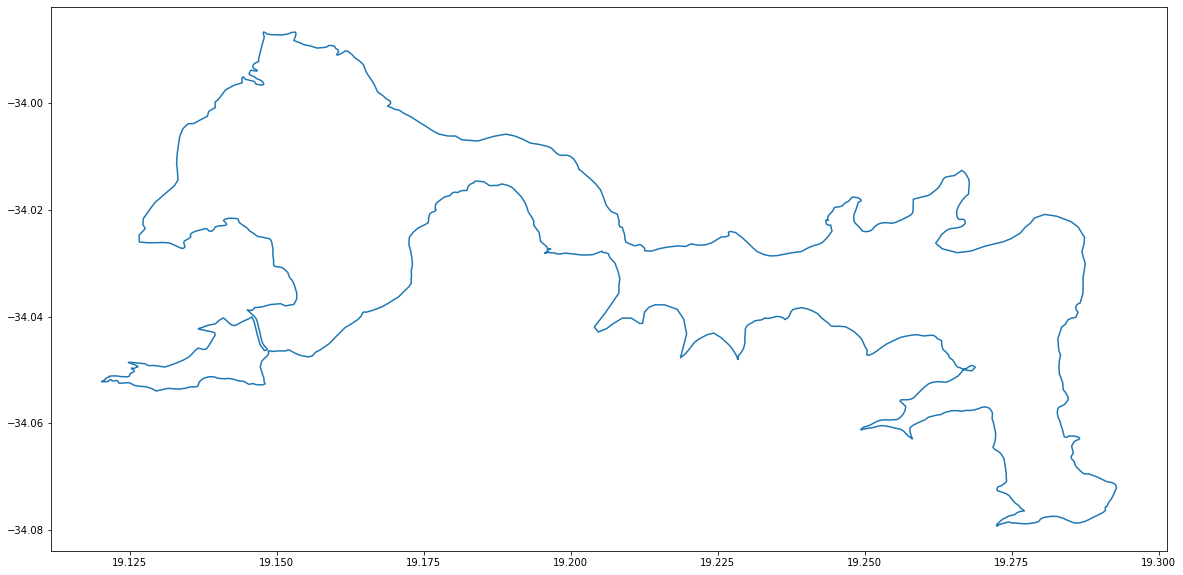

In [34]:
# and plot it
plot_geometry(geom)

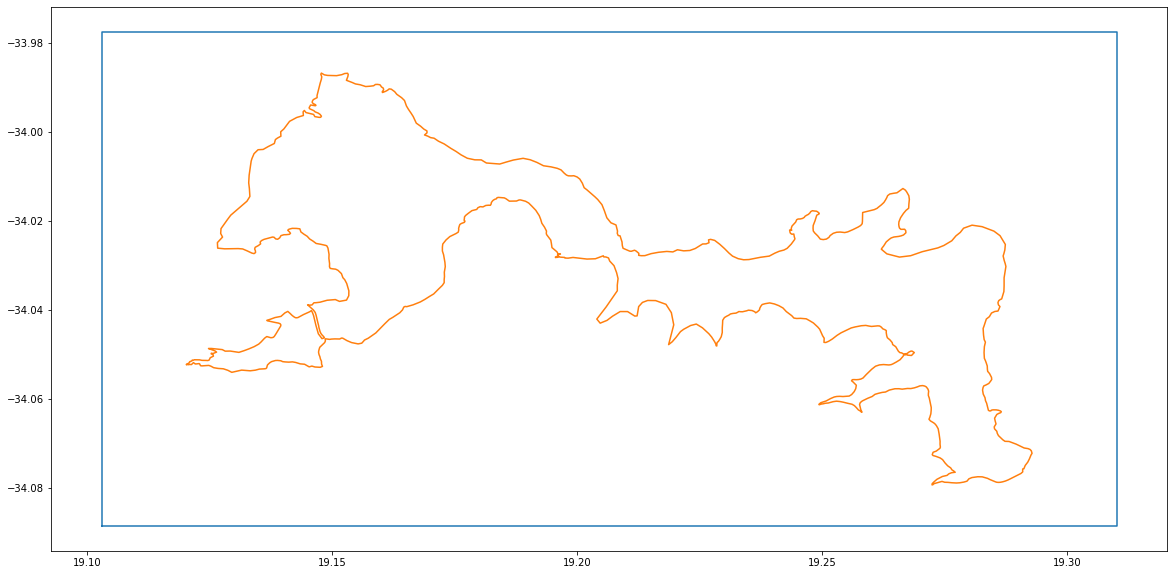

In [35]:
# create BBox instance
bbox = get_bbox(geom, inflate_bbox=0.1)

# plot the BBox and the geometry
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plot_geometry(bbox.geometry, ax)
plot_geometry(geom, ax)

In [106]:
# calculate fraction of pixels with non-zero values
def coverage(array):
    return 1.0 - np.count_nonzero(array)/np.size(array)

# a function to return valid data for the area as a union of pixels with non-zero values and pixels that contain no clouds
class ValidDataPredicate:
    def __call__(self, eopatch):     
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

# definition of a task to calculate and add the valid coverage scalar to the EOPatch
class AddValidDataCoverage(EOTask):
    def execute(self, eopatch):
        
        vld = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA')
        
        cvrg = np.apply_along_axis(coverage, 1, np.reshape(vld, (vld.shape[0], vld.shape[1]*vld.shape[2])))
        
        eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', cvrg[:,np.newaxis])
        return eopatch

# definition of a task for water mask and water level detection
class WaterDetector(EOTask):
    def execute(self, eopatch):
        
        results = [get_water_level_optical(date, eopatch.data['NDWI'][idx,...,0], geom, bbox, simplify=True) for idx, date in enumerate(eopatch.timestamp)]
        
        df = list([x['geometry'] for x in results])
        gdf = gpd.GeoDataFrame(geometry = df, crs = {'init': eopatch.bbox.crs.ogc_string()})
        gdf['TIMESTAMP'] = eopatch.timestamp
        
        eopatch.add_feature(FeatureType.VECTOR, 'WATER_OUTLINE', gdf)
        eopatch.add_feature(FeatureType.SCALAR, 'WATER_LEVEL', np.array([x['water_level'] for x in results])[..., np.newaxis])
        
        return eopatch

In [17]:
# TASK for downloading RGB bands
# `TRUE-COLOR-S2-L1C` is the name of the layer defined in the Sentinel Hub configurator.
# the arguments are the resolution of the image, max cloud coverage of the whole Satellite tile, and the instance ID for your Sentinel Hub account
input_task = S2L1CWCSInput(layer='TRUE-COLOR-S2-L1C', 
                           resx='20m', resy='20m', maxcc=0.5, 
                           instance_id=None)

NameError: name 'S2L1CWCSInput' is not defined

In [ ]:
task = SentinelHubInputTask(
            bands_feature=(FeatureType.DATA, 'BANDS'),
            additional_data=[(FeatureType.MASK, 'dataMask')],
            size=self.size,
            maxcc=self.maxcc,
            time_difference=self.time_difference,
            data_collection=DataCollection.SENTINEL2_L1C,
            max_threads=self.max_threads,
            cache_folder=cache_folder
        )

In [ ]:
# TASK for downloading the NDWI band combination
# other parameters are copied from the previous task
add_ndwi = S2L1CWCSInput('NDWI')

In [6]:
# TASK for cloud detection
# cloud probability map (CLP) and cloud mask (CLM) are calculated at 160 m resolution in order to speed up the process
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
cloud_det = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='160m', cm_size_x='160m', 
                             cmask_feature='CLM', cprobs_feature='CLP', instance_id=None)

NameError: name 'get_s2_pixel_cloud_detector' is not defined

In [54]:
# TASK for adding a raster mask of the nominal water extent (NOMINAL_WATER) 
# raster shape is provided by an existing feature inside of the EOPatch
gdf = gpd.GeoDataFrame(crs={'init':'epsg:4326'}, geometry=[geom])
add_nominal_water = VectorToRaster(feature=(FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'), 
                                   vector_data=gdf, raster_value=1, 
                                   raster_shape=(FeatureType.MASK, 'IS_DATA'), 
                                   raster_dtype=np.uint8)

TypeError: __init__() missing 2 required positional arguments: 'vector_input' and 'raster_feature'

In [ ]:
# TASK for adding valid data mask to the EOPatch (mask type)
add_valmask = AddValidDataMaskTask(predicate=ValidDataPredicate())

In [ ]:
# TASK for adding valid data coverage to the EOPatch (scalar type)
add_coverage = AddValidDataCoverage()

In [107]:
# TASK for water detection
water_det = WaterDetector()

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import numpy as np
from aenum import MultiValueEnum
from matplotlib.colors import ListedColormap, BoundaryNorm

from sentinelhub import BBox, CRS, DataCollection, MimeType, SentinelHubRequest, SHConfig

from eolearn.core import SaveTask, LoadTask, FeatureType, LinearWorkflow
from eolearn.io import SentinelHubInputTask, SentinelHubDemTask, SentinelHubEvalscriptTask, get_available_timestamps

In [66]:
# region of interest
#roi_bbox = BBox(bbox=[5.60, 52.68, 5.75, 52.63], crs=CRS.WGS84)
roi_bbox = bbox

# time interval of downloaded data
time_interval = ('2018-07-01', '2021-03-01')

# maximal cloud coverage (based on Sentinel-2 provided tile metadata)
maxcc = .8

# resolution of the request (in metres)
resolution = 20

# time difference parameter (minimum allowed time difference; if two observations are closer than this, they will be mosaicked into one observation)
time_difference = datetime.timedelta(hours=2)

In [67]:
config = SHConfig()
config

SHConfig(
  instance_id='87058221-bde9-4ad1-b9e0-8f471fb7bc20',
  sh_client_id='a2d3a306-4002-4a32-a9ef-b2c91e4bf611',
  sh_client_secret='3[G%@-Et@Q81|w3^)#Nd/;P#od)!|RUW)QfZQ)L!',
  sh_base_url='https://services.sentinel-hub.com',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5,
  download_timeout_seconds=120,
  number_of_download_processes=1
)

In [68]:

input_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'],
    bands_feature=(FeatureType.DATA, 'L1C_data'),
    additional_data=[(FeatureType.MASK, 'dataMask')],
    resolution=resolution,
    maxcc=maxcc,
    time_difference=time_difference,
    config=config,
    max_threads=3
)

In [69]:
indices_evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: ["B03","B04","B08","dataMask"],
            output:[{
                id: "indices",
                bands: 2,
                sampleType: SampleType.FLOAT32
            }]
        }
    }

    function evaluatePixel(sample) {
        let ndvi = index(sample.B08, sample.B04);
        let ndwi = index(sample.B03, sample.B08);
        return {
           indices: [ndvi, ndwi]
        };
    }
"""

In [70]:

# this will add two indices: ndvi and ndwi
add_indices = SentinelHubEvalscriptTask(
    features=[(FeatureType.DATA, 'indices')],
    evalscript=indices_evalscript,
    data_collection=DataCollection.SENTINEL2_L1C,
    resolution=resolution,
    maxcc=maxcc,
    time_difference=time_difference,
    config=config,
    max_threads=3
)

In [71]:

add_dem = SentinelHubDemTask(
    data_collection=DataCollection.DEM_COPERNICUS_30, 
    resolution=resolution, 
    config=config
)

In [72]:
add_l2a_and_scl = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L2A,
    bands=['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12'],
    bands_feature=(FeatureType.DATA, 'L2A_data'),
    additional_data=[(FeatureType.MASK, 'SCL')],
    resolution=resolution,
    maxcc=maxcc,
    time_difference=time_difference,
    config=config,
    max_threads=3
)

In [73]:
save = SaveTask('io_example', overwrite_permission=2, compress_level=1)

In [74]:
workflow = LinearWorkflow(input_task, add_indices, add_l2a_and_scl, add_dem, save)

result = workflow.execute({
    input_task: {'bbox': roi_bbox, 'time_interval': time_interval},
    save: {'eopatch_folder': 'eopatch'}
})

In [75]:
eopatch = result.eopatch()
eopatch

EOPatch(
  data: {
    L1C_data: numpy.ndarray(shape=(167, 633, 945, 13), dtype=float32)
    L2A_data: numpy.ndarray(shape=(167, 633, 945, 12), dtype=float32)
    indices: numpy.ndarray(shape=(167, 633, 945, 2), dtype=float32)
  }
  mask: {
    SCL: numpy.ndarray(shape=(167, 633, 945, 1), dtype=uint8)
    dataMask: numpy.ndarray(shape=(167, 633, 945, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    dem: numpy.ndarray(shape=(633, 945, 1), dtype=uint16)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    size_x: 945
    size_y: 633
    time_difference: datetime.timedelta(0, 1)
    time_interval: None
  }
  bbox: BBox(((19.103061540000002, -34.0884953), (19.31009946, -33.977425700000005)), crs=CRS('4326'))
  timestamp: [datetime.datetime(2018, 7, 5, 8, 43, 58, tzinfo=tzutc()), ...], length=167
)

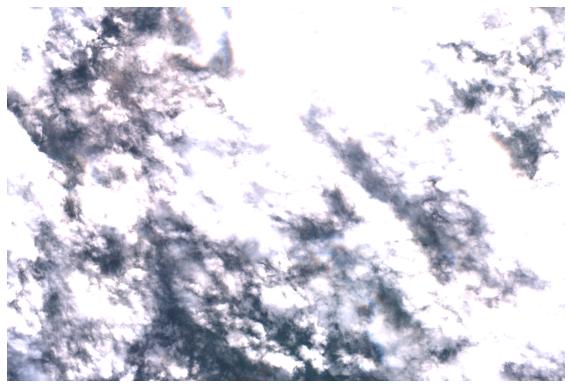

In [86]:
plt.figure(figsize=(10,10))
plt.imshow(np.clip(eopatch.data['L1C_data'][3][..., [3,2,1]] * 2.5, 0, 1), vmin=0, vmax=1);
plt.axis(False);

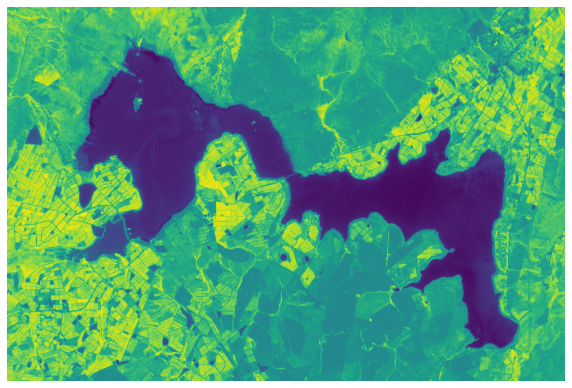

In [91]:
plt.figure(figsize=(10,10))
plt.imshow(eopatch.data['indices'][90][...,0].squeeze());
plt.axis(False);

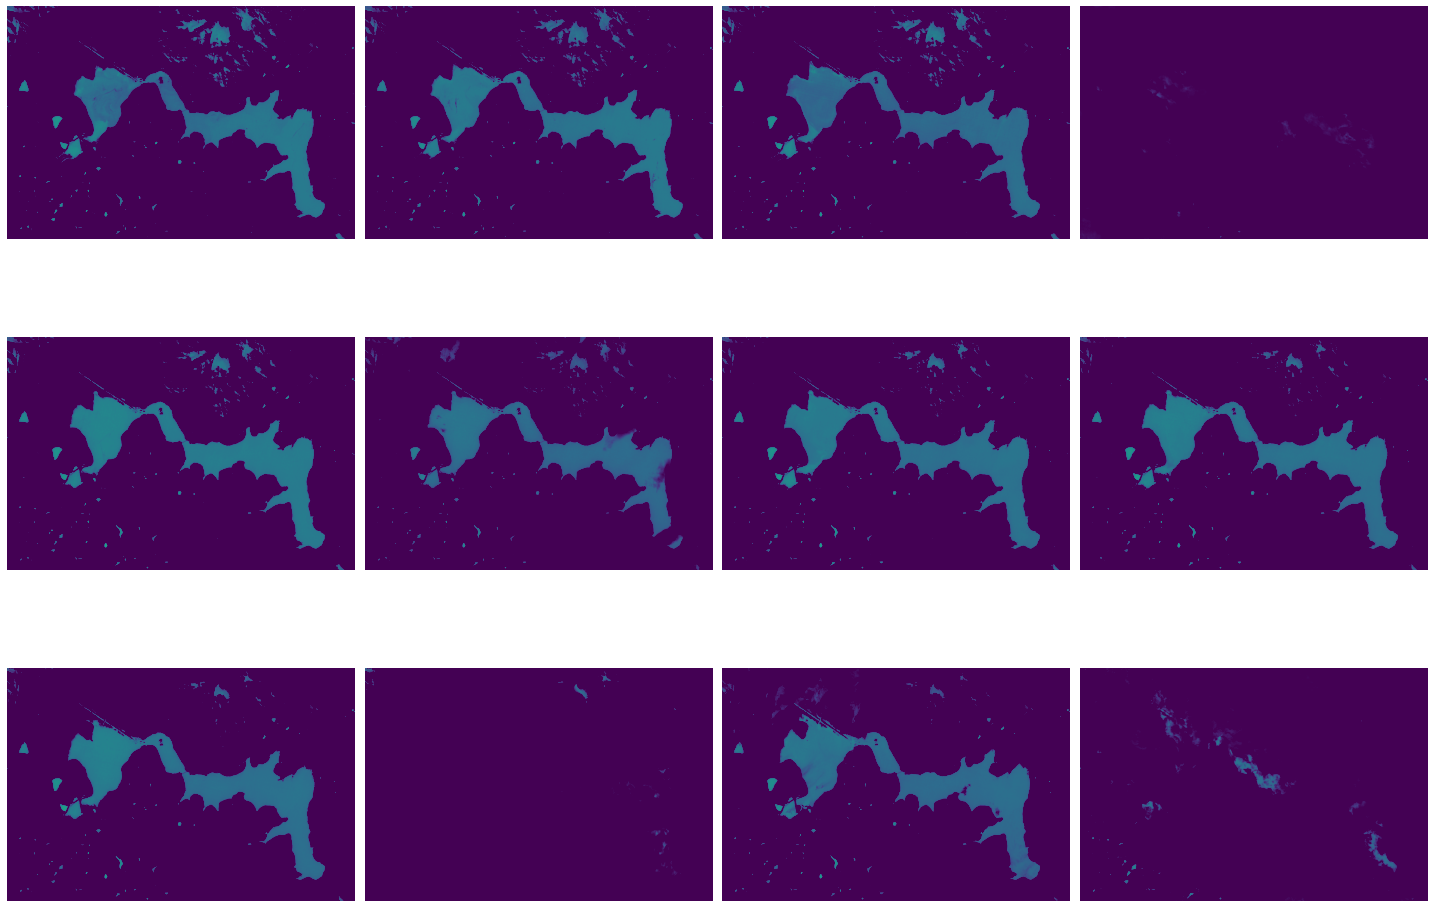

In [101]:
# get aspect ratio of image for better plotting
#image_ar = eopatch.mask_timeless['NOMINAL_WATER'].shape[0] / eopatch.mask_timeless['NOMINAL_WATER'].shape[1]

# plot the NDWI at different dates
#fig = plt.figure(figsize=(20,15*image_ar))
fig = plt.figure(figsize=(20,15))

for i in range(12):
    ax = plt.subplot(3,4,i+1)
    ax.imshow(eopatch.data['indices'][i][...,1].squeeze(), vmin = 0, vmax = 1)
    ax.axis('off')
    
plt.tight_layout(pad=1)

KeyError: 'WATER_OUTLINE'

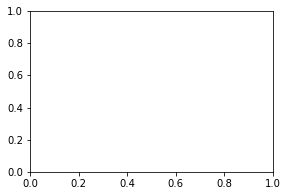

In [108]:
def plot_waterbody(img, date, dam_poly, dam_bbox, water_extent, water_level, 
                    color_nominal='white', color_current='xkcd:lime', ax = None):

    shape = img.shape[0:2]
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
        
    ax.imshow(img,extent=[dam_bbox.min_x,dam_bbox.max_x,dam_bbox.min_y,dam_bbox.max_y])
        
    if isinstance(dam_poly, Polygon):
        draw_poly(ax,dam_poly, color=color_nominal)
    elif isinstance(dam_poly, MultiPolygon):
        draw_multi(ax,dam_poly, color=color_nominal)
        
    if isinstance(water_extent, Polygon):
        draw_poly(ax,water_extent, color=color_current)
    elif isinstance(water_extent, MultiPolygon):
        draw_multi(ax, water_extent, color=color_current)


# get aspect ratio of image for better plotting
image_ar = eopatch.data['L1C_data'][0].shape[0] / eopatch.data['L1C_data'][0].shape[1]

fig = plt.figure(figsize=(20,15*image_ar))

for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plot_waterbody(eopatch.data['L1C_data'][i], eopatch.timestamp[i], geom, bbox, eopatch.vector['WATER_OUTLINE']['geometry'][i], eopatch.scalar['WATER_LEVEL'][i], ax=ax)
    ax.axis('off')
    
plt.tight_layout(pad=0)  